In [1]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
import cv2
import numpy as np
import torch, torchvision

In [2]:
df_dir = '/content/drive/MyDrive/PROJECTS/ObjectLocalization/Marvel Vs StarWars/df.csv'
checkpoint_path = '/content/drive/MyDrive/PROJECTS/ObjectLocalization/Marvel Vs StarWars/Checkpoints/model_checkpoint.pth'

In [3]:
df = pd.read_csv(df_dir)
df.head(1)

,image_path,marvel,starwars,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/PROJECTS/ObjectLocaliza...,1,0,63.0,18.0,395.0,506.0


In [4]:
# Custom Dataloader
class LoadDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.df.iloc[index, 0]
        img = cv2.imread(img_path)
        if self.transform:
            img = self.transform(img)
        label = torch.from_numpy(self.df.iloc[index, 1:].values.astype(float))
        return (img, label)

In [5]:
img_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=[0.485, 0.456, 0.406], 
    #     std=[0.229, 0.224, 0.225]
    # )
])

In [6]:
dataset = LoadDataset(df=df, transform=img_to_tensor)
dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
from models import ResNet18

model = ResNet18(df=df, device=device, pretrained_weights=True)

In [9]:
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

In [10]:
current_loss = 9999999.
for epoch in range(100):
    model.train()
    train_losses = []
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        optimizer.zero_grad()
        loss = loss_fn(outputs.to(float), labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
    if epoch % 10 == 0:
        torch.save(model.state_dict(), checkpoint_path)
        print(f'Epoch: {epoch}, Train Loss: {np.sum(train_losses)/len(train_losses):.2f}')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0, Train Loss: 40180.32
Epoch: 10, Train Loss: 953.34
Epoch: 20, Train Loss: 819.37
Epoch: 30, Train Loss: 676.63
Epoch: 40, Train Loss: 439.92
Epoch: 50, Train Loss: 346.27
Epoch: 60, Train Loss: 228.31
Epoch: 70, Train Loss: 127.77
Epoch: 80, Train Loss: 61.97
Epoch: 90, Train Loss: 20.51


In [11]:
from evaluation_metrics import IoU
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [12]:
def predictNplot(index=0):

    fig, ax = plt.subplots(1, figsize=(15,8))

    # index = 0
    img_path = df.iloc[index, 0]

    img = cv2.imread(img_path)
    img_transform = img_to_tensor(img)
    img_transform = img_transform.unsqueeze(0)

    ax.imshow(img)

    model.eval()
    output = model(img_transform.to(device))
    output = output.cpu().detach()
    model.train()

    label = torch.from_numpy(df.iloc[index, 1:].values.astype(float)).unsqueeze(0)

    iou = IoU(boxes_labels=label[output.shape[0]-1][..., 2:], boxes_preds=output[..., 2:], boxes_format='corner')
    print(f'IoU score = {(iou.sum()/len(iou)).item():.4f}')
    plt.title(f'IoU score = {(iou.sum()/len(iou)).item():.4f}')

    output = output.detach().cpu().numpy()[0]
    coord_preds = output[2:]
    initial_position_pred = (coord_preds[0], coord_preds[1])
    width_pred, height_pred = coord_preds[2]-coord_preds[0], coord_preds[3]-coord_preds[1]
    reactangle_pred = patches.Rectangle(
        initial_position_pred,
        width_pred, height_pred,
        linewidth=3,
        edgecolor='red', facecolor='none'
    )
    ax.add_patch(reactangle_pred)

    labels = output[0:2]
    # np.where(label==1.)[0][0]
    columns = df.columns[1:3]
    label = columns[np.argmax(output[:2])]
    ax.text(
        coord_preds[0]+5, coord_preds[1]-5,
        '{}'.format(label), color='red'
    )
    # ax.text(
    #     coord_preds[0]+5, coord_preds[1]-5,
    #     '{}(Predicted)'.format(label), color='red'
    # )

    coordinates = df.iloc[index, 3:].values
    initial_position = (coordinates[0], coordinates[1])
    width, height = coordinates[2]-coordinates[0], coordinates[3]-coordinates[1]
    reactangle = patches.Rectangle(
        initial_position,
        width, height,
        linewidth=3,
        edgecolor='green', facecolor='none'
    )
    ax.add_patch(reactangle)

    labels = df.iloc[index, 1:4].values
    # np.where(label==1.)[0][0]
    columns = df.columns[1:4]
    label = columns[np.where(labels==1.)[0][0]]
    # ax.text(
    #     coordinates[0]+5, coordinates[3]+15,
    #     '{}(Actual)'.format(label), color='green'
    # )
    ax.text(
        coordinates[0]+5, coordinates[3]+15,
        '{}'.format(label), color='green'
    )

    plt.show()

IoU score = 0.4833


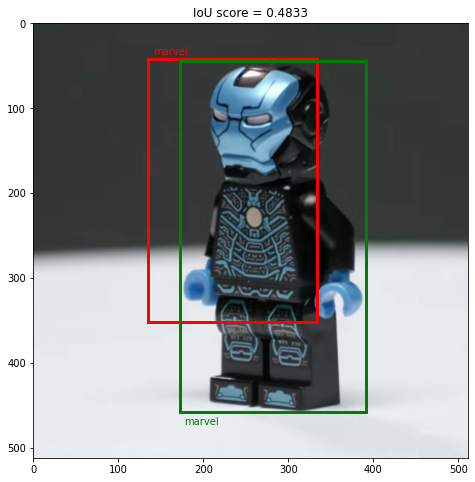

In [25]:
# predictNplot(np.random.randint(0, len(df)))
predictNplot(index=25)